@dataset{
    dataset,
    author = {Timilsina, Bimal},
    year = {2021},
    month = {08},
    pages = {},
    title = {News Article Category Dataset},
}

In [1]:
import pandas as pd

In [2]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

In [3]:
df['category'] = df['category'].astype('category')

In [4]:
categories = pd.read_csv('../input/category_map.csv', index_col=1, dtype={'CATEGORY': 'category', 'SUB_CATEGORY': 'category'})

In [5]:
category_mapping = categories.to_dict()['CATEGORY']

In [7]:
df['main_category'] = df['category'].map(category_mapping)

In [9]:
from sklearn.model_selection import train_test_split

x = df['headline'] + ' ' + df['short_description']
y = df

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y['category'])

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, ngram_range=(1, 2), max_features=5000)

In [20]:
tfidf_article_matrix = vectorizer.fit_transform(x_train)

In [30]:
articles_by_category = x_train.groupby(y_train['category'], observed=True).apply(lambda x: ' '.join(x.astype(str))).reset_index(name='all_articles')

In [31]:
display(articles_by_category.head())

,category,all_articles
0,ARTS,Music in the Southwest Part 2: The Tucson Symp...
1,ARTS & CULTURE,Duncan Jones Finds A Literary Way To Remember ...
2,BLACK VOICES,One In Seven NFL Players Protested Yesterday. ...
3,BUSINESS,Volkswagen Works Council Set To Seek Labor Rep...
4,COLLEGE,We're All on Our Way Out: 16 Pieces of Advice ...


In [36]:
tfid_sub_matrix = vectorizer.fit_transform(articles_by_category['all_articles'])

In [135]:
from sklearn.cluster import DBSCAN

cluster_results = DBSCAN(eps=.5, min_samples=1).fit(tfid_sub_matrix)

In [136]:
print(cluster_results.labels_)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 22
 23 24 25 26 27 28 29 13 30 31 32 33 34 35 16 36 37 38]


In [137]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans_results = kmeans.fit(tfid_sub_matrix)

In [138]:
print(kmeans_results.labels_)

[1 1 3 0 2 1 3 1 2 2 1 0 2 2 2 0 0 2 0 1 1 2 2 2 1 2 0 0 2 2 2 2 2 3 2 3 2
 2 0 2 3 3]


In [139]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='random')
reduced_data = tsne.fit_transform(tfid_sub_matrix)

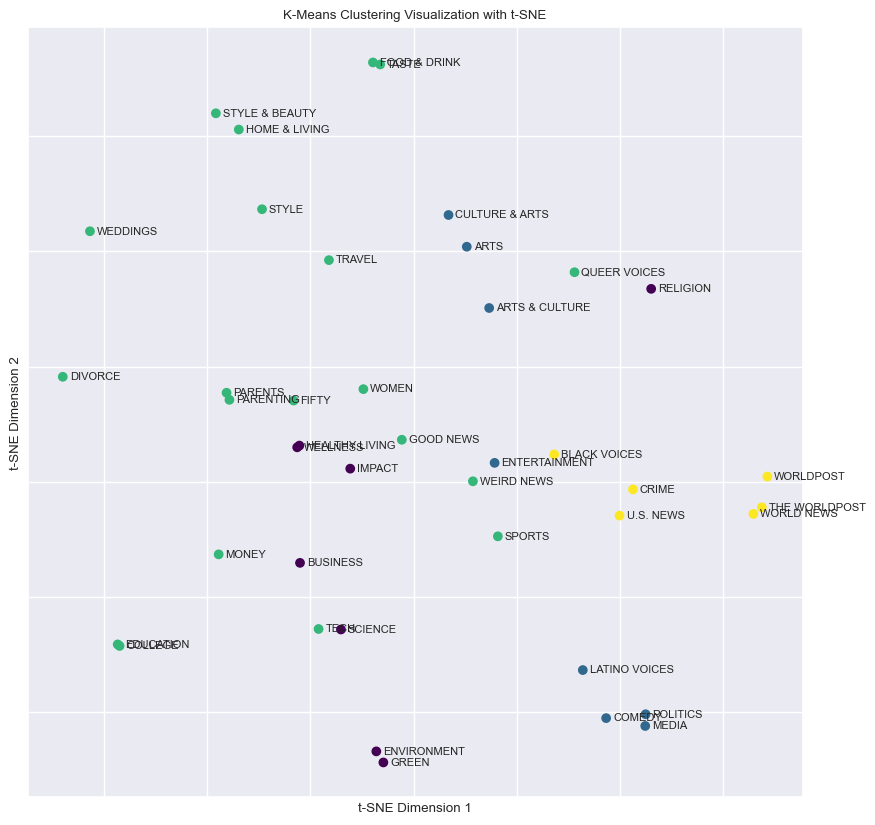

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_results.labels_, cmap='viridis')
plt.title('K-Means Clustering Visualization with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False,
)

for i, name in enumerate(articles_by_category['category']):
    plt.annotate(name, xy=(reduced_data[i, 0], reduced_data[i, 1]), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=8)

plt.show()

In [41]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(tfid_sub_matrix)
labels = dbscan.labels_

In [44]:
print(dbscan.components_)

[]


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(vectorizer, MultinomialNB())

model.fit(x_train, y_train['main_category'])


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [17]:
labels = model.predict(x_test)

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

category_names = pd.unique(y_train['main_category'])
print(classification_report(y_test['main_category'], labels, target_names=category_names))
mat = confusion_matrix(y_test['main_category'], labels, labels=category_names)
f1_score_result = f1_score(y_test['main_category'], labels, average='micro')

               precision    recall  f1-score   support

      SCIENCE       0.73      0.78      0.76     12604
    LIFESTYLE       0.66      0.57      0.61      8051
ENTERTAINMENT       0.76      0.83      0.79     14648
         NEWS       0.73      0.61      0.67      6603

     accuracy                           0.73     41906
    macro avg       0.72      0.70      0.71     41906
 weighted avg       0.73      0.73      0.73     41906



0.7304204648499022
[[ 4056   795   864   888]
 [  652  4572  1505  1322]
 [  385   804  9875  1540]
 [  499   752  1291 12106]]


Text(-3.250000000000007, 0.5, 'predicted label')

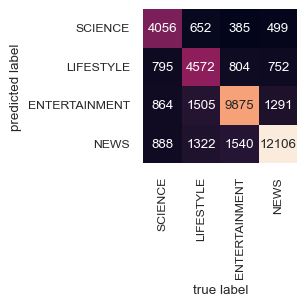

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np

np.set_printoptions(threshold=1000)

print(f1_score_result)

print(mat)

plt.rcParams.update({'font.size': 8, 'figure.figsize': [2, 2]})
sns.set(font_scale=0.8)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=category_names, yticklabels=category_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [144]:
headline = input('Enter a headline')
model.predict([headline])

array(['NEWS'], dtype='<U13')